Here we want to experiment with getting a similar random forest model running. Then we need to develop a pipeline for a feature selection process. Then finally we need to have a process set up to try different machine learning architectures for tabular datasets (and hyperparameter tuning included).

In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# load in the dataset
df = pd.read_csv('depth_dataset.csv', index_col='system:index')
df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index2,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,depth
system:index,,,,,,,,,,,,,,,,,,,,,
0,25.850000,13.200000,19.629999,661.375000,31,1.9250,873.312500,21,43,4,...,-14.972229,8.805004,-19.374731,-10.569727,9,53,14.117304,651.920227,60.827629,0
1,27.400000,13.140000,19.549999,1203.100000,30,2.1725,1350.500000,20,75,5,...,-15.681625,9.046126,-20.204688,-11.158562,9,53,13.949217,1956.041870,67.082039,0
2,81.459999,45.310001,37.349998,387.343750,17,-0.7450,647.781250,4,86,1,...,-15.333398,6.494423,-18.580610,-12.086187,0,3,13.371652,60.827629,20.000000,0
3,20.490000,9.000000,23.410000,423.250000,29,-1.2700,705.222222,4,78,0,...,-15.737561,5.918675,-18.696899,-12.778224,9,54,12.453618,60.000000,10.000000,50
4,20.490000,9.000000,23.410000,529.416667,21,-0.4300,888.416667,4,54,3,...,-16.688597,6.344463,-19.860828,-13.516365,9,54,13.459080,70.000000,30.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,86.190002,47.299999,32.860001,625.344828,21,1.9125,912.241379,8,100,5,...,-16.102811,5.956158,-19.080890,-13.124732,0,3,13.984183,94.339813,78.102501,272
167,86.190002,47.299999,32.860001,685.965517,21,2.1675,1011.172414,8,88,5,...,-16.060745,6.051995,-19.086743,-13.034748,0,3,12.903586,136.014709,10.000000,325
168,86.190002,47.299999,32.860001,394.433333,35,1.7300,557.966667,1,60,5,...,-10.917043,7.312031,-14.573058,-7.261027,0,3,14.025423,277.308472,42.426407,330


In [4]:
# get the feature names from the column headings 
feature_names = [i for i in df.columns]
feature_names.remove('depth')

In [5]:
# set aside 10% of the data for testing
splits_test = TrainTestSplitter(test_size=0.1, random_state=42, shuffle=True)(df)
test_df = df.iloc[splits_test[1],:]

# some models need explicit datasets
x_test = test_df.drop('depth', axis=1)
y_test = test_df['depth']

In [6]:
# the remaining data (known as just our data now) should be split into training and validation sets 
df = df.iloc[splits_test[0],:]
splits_train_val = RandomSplitter(valid_pct=0.2, seed=42)(df)

# for some models we need explicit datasets
x_train = df.iloc[splits_train_val[0],:].drop('depth', axis=1)
y_train = df.iloc[splits_train_val[0],:]['depth']

x_val = df.iloc[splits_train_val[1],:].drop('depth', axis=1)
y_val = df.iloc[splits_train_val[1],:]['depth']

# Data Exploration

In [7]:
# plot the distribution of each predictor (some methods want normally distrbuted not long tail e.g.)
#df.hist(feature_names);

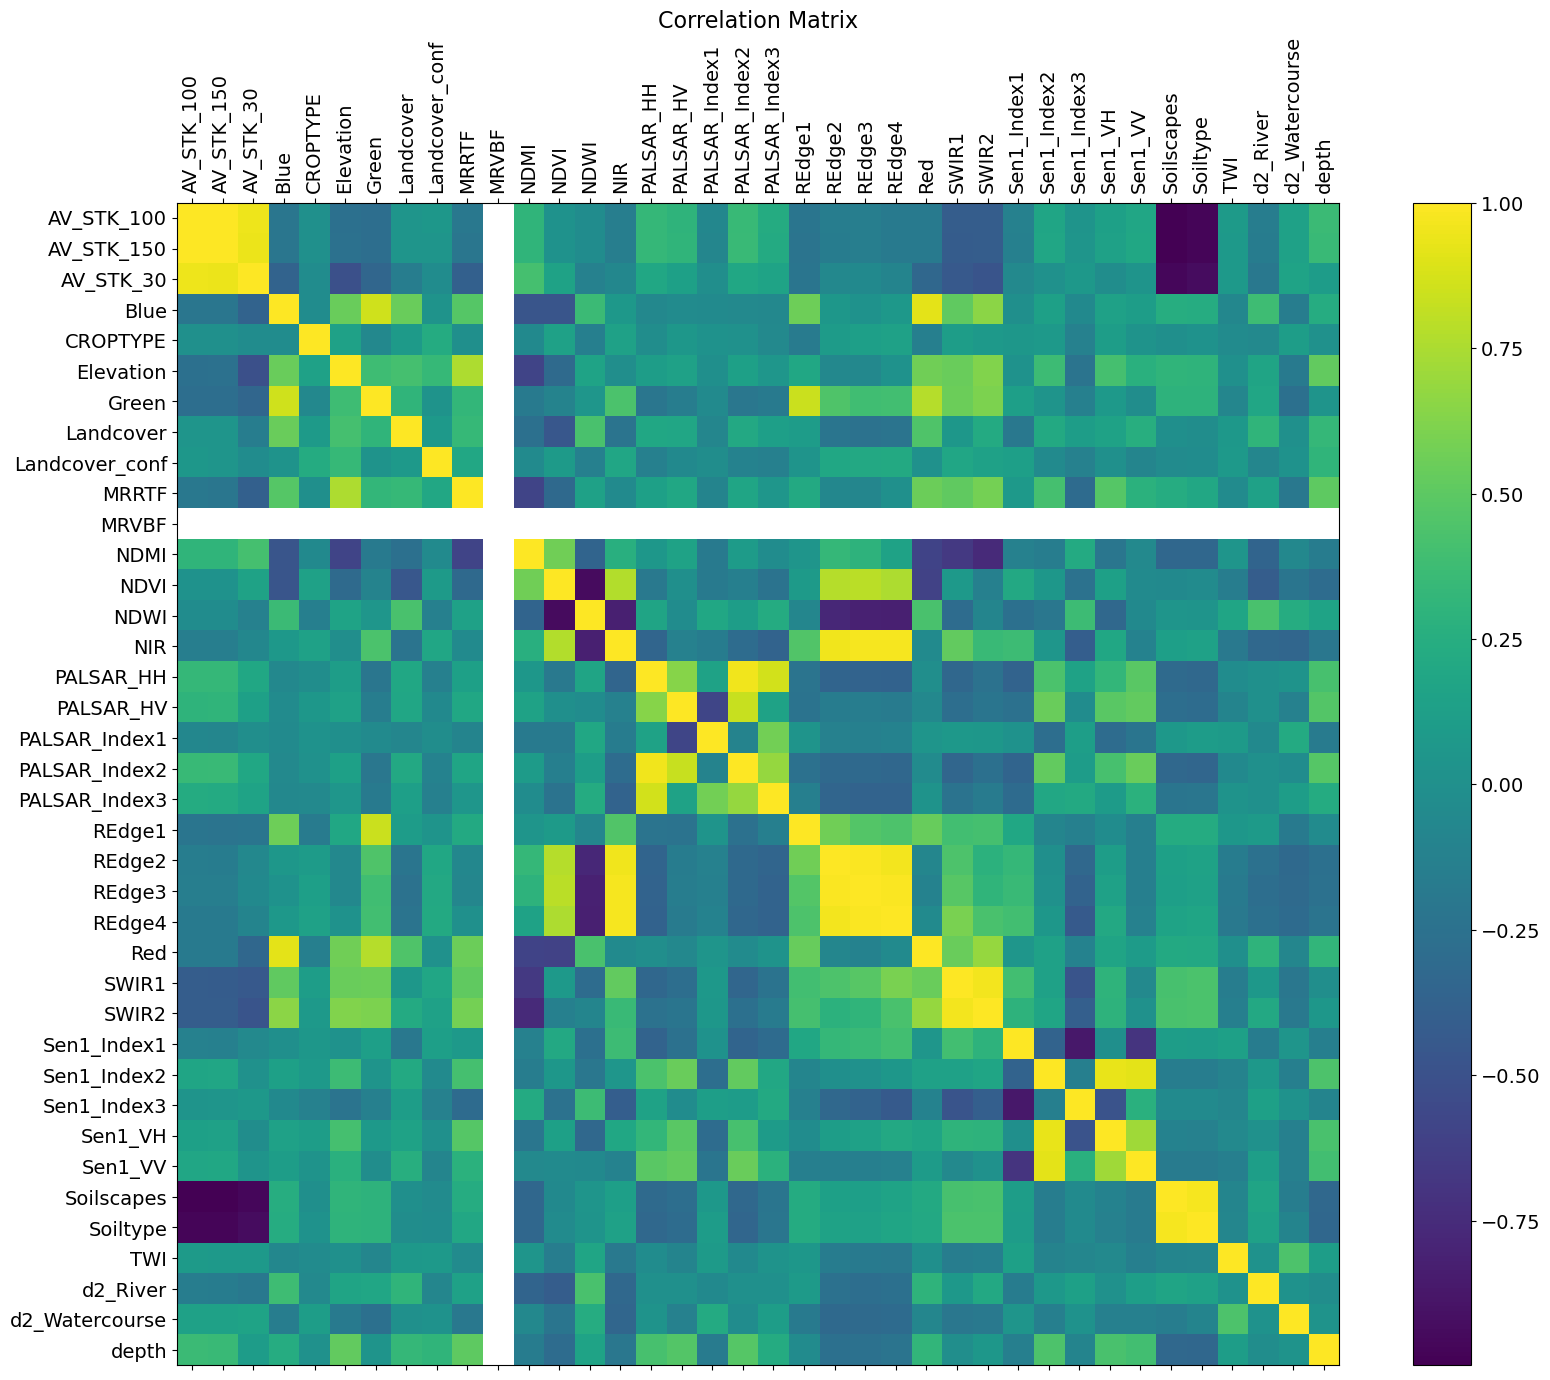

In [8]:
# plot the correlation matrix between all the predictors 
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Random Forest

In [9]:
# instantiate the random forest regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train, x_val]), pd.concat([y_train, y_val])) 

RandomForestRegressor(oob_score=True, random_state=0)

In [10]:
# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

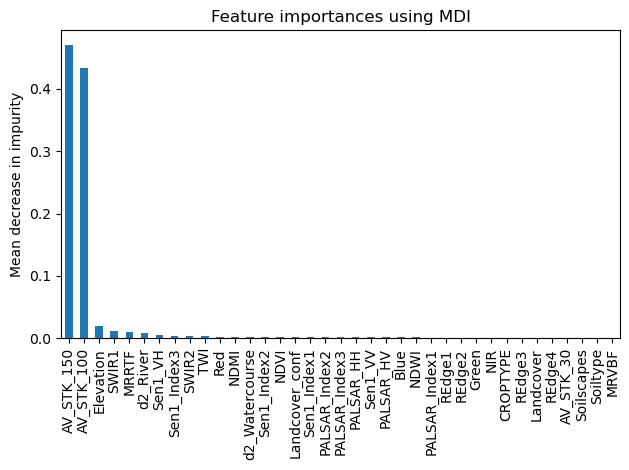

In [11]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [12]:
y_pred_train_val = rf_model.predict(pd.concat([x_train, x_val]))
y_pred_test = rf_model.predict(x_test)

In [13]:
# Out of bag error is the average error given by trees on datapoints not used to train those trees? score?
print("Out of bag error:")
print(rf_model.oob_score_)

Out of bag error:
0.9430940054867714


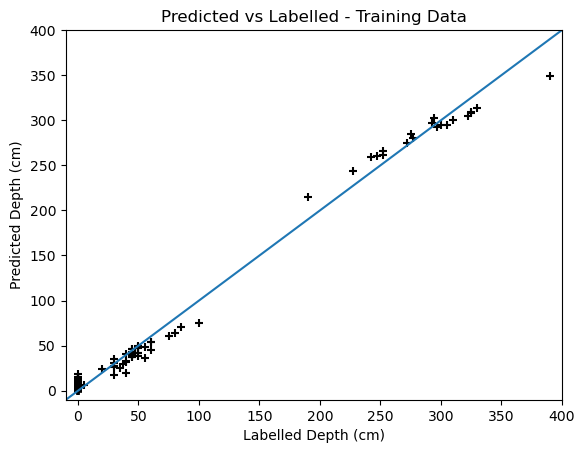

In [14]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train, y_val]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [15]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(pd.concat([y_train, y_val]), y_pred_train_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train, y_val]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9921368630710877
RMSE: 8.490021016625642


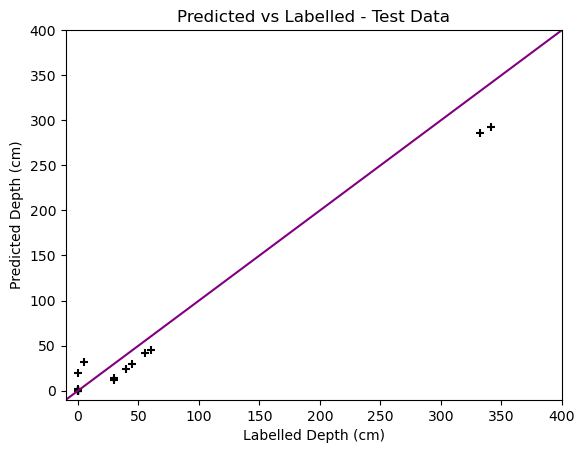

In [16]:
# add a scatter plot of the data points
plt.scatter(y_test, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [17]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, y_pred_test, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9629530235494916
RMSE: 19.75939045393635


In [18]:
# study the partial dependence between the predicted thickness and predictors 
#from sklearn.inspection import PartialDependenceDisplay
#PartialDependenceDisplay.from_estimator(rf_model, x_train, ['AV_STK_100'])

# Gradient Boosting Machine 

In [19]:
df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index2,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,depth
system:index,,,,,,,,,,,,,,,,,,,,,
140,81.459999,45.310001,37.349998,399.733333,31,-1.3375,638.333333,4,44,0,...,-13.306883,6.834219,-16.723993,-9.889774,0,3,13.656886,280.178497,85.440033,45
24,81.459999,45.310001,37.349998,490.216216,24,-1.5875,759.081081,3,41,3,...,-16.839000,7.152805,-20.415402,-13.262597,0,3,12.969288,36.055511,10.000000,80
60,81.459999,45.310001,37.349998,337.500000,7,-1.4475,502.375000,5,48,0,...,-16.973722,7.945064,-20.946253,-13.001190,0,3,13.651308,296.816437,102.956306,55
167,86.190002,47.299999,32.860001,685.965517,21,2.1675,1011.172414,8,88,5,...,-16.060745,6.051995,-19.086743,-13.034748,0,3,12.903586,136.014709,10.000000,325
19,81.459999,45.310001,37.349998,410.884615,27,-0.1600,716.923077,4,95,2,...,-15.775420,6.167606,-18.859223,-12.691617,0,3,12.229239,41.231056,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,20.490000,9.000000,23.410000,476.538462,10,0.7250,799.769231,4,57,4,...,-16.527572,5.886110,-19.470628,-13.584517,9,54,14.618917,460.000000,50.000000,0
106,81.459999,45.310001,37.349998,420.200000,7,-1.5450,639.133333,5,54,0,...,-15.433117,10.202786,-20.534510,-10.331724,0,3,13.880654,128.062485,36.055511,50
14,20.490000,9.000000,23.410000,500.794118,21,-0.0525,777.294118,8,52,4,...,-16.774904,6.266972,-19.908390,-13.641417,9,54,14.164667,82.462112,44.721359,0


# Neural Net (fastai)

In [20]:
# May need some initial pre-processing steps here e.g. log transforms 

In [21]:
# get data ready for training by specifying what Tabular data loader needs to know 
#   df = dataframe working with
#   splits = indexs used for training and testing
#   procs = pre-processing steps (we don't use categorify and fill missing since already proceessed)
#   cat_names = names of categorical data columns
#   cont_names = names of columns with continuous data
#   y_names = label column name
#   y_block = either CategoryBlock or RegressionBlock depending on target type
dls = TabularPandas(
    df, 
    splits=splits_train_val,
    procs = [Categorify, Normalize],
    cat_names=["CROPTYPE", "Landcover", "MRRTF", "MRVBF", "Soilscapes", "Soiltype",],
    cont_names=['AV_STK_100', 'AV_STK_150', 'AV_STK_30', 'Blue', 'Elevation', 'Green', 'NDMI', 'NDVI', 'NDWI', 'NIR',
                'PALSAR_HH', 'PALSAR_HV', 'PALSAR_Index1', 'PALSAR_Index2', 'PALSAR_Index3', 'REdge1', 'REdge2', 
                'REdge3', 'REdge4', 'Red', 'SWIR1', 'SWIR2', 'Sen1_Index1', 'Sen1_Index2', 'Sen1_Index3', 'Sen1_VH', 
                'Sen1_VV', 'TWI', 'd2_River', 'd2_Watercourse', 'Landcover_conf'],
    y_names="depth", 
    y_block = RegressionBlock(),
).dataloaders(path=".")

In [22]:
# Build a learner (model + data)
# we specify the size of each HIDDEN layer (doesn't matter how many inputs we have or outputs, just the main body of model)
learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[200,100])

In [23]:
# we never want negative preidictions so add a ReLU to the final layer
learn.model.layers.add_module("ReLU", nn.ReLU(inplace=True))

In [24]:
# to see the exact architecture that fastai specifies when using the TabularLearner function we call learn.model
# we use embeddings, dropout, batchnorm and 2 hidden layers in our network
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(7, 5)
    (2): Embedding(8, 5)
    (3): Embedding(2, 2)
    (4): Embedding(4, 3)
    (5): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=58, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (ReLU): ReLU(inplace=True)
  )
)

In [25]:
#learn.lr_find(suggest_funcs=(slide, valley))

In [26]:
# I'm guessing we need a large learning rate since we have so many features that travessing the space of optimal weights
# takes a long time. When we have done feature selection this won't be so much of a problem
learn.fit(25, lr=0.1)
learn.fit(15, lr=0.01)

epoch,train_loss,valid_loss,_rmse,r2_score,time
0,7022.434570,13607.418945,116.650841,-0.316292,00:00
1,7576.720703,6900.754395,83.070778,0.332467,00:00
2,9688.254883,4184.071777,64.684402,0.595260,00:00
3,9287.789062,2978.471436,54.575375,0.711882,00:00
4,8417.713867,1951.893921,44.180244,0.811187,00:00
5,7831.359375,1348.590942,36.723167,0.869546,00:00
6,7286.403320,1028.166382,32.065033,0.900542,00:00
7,6525.306641,4276.474609,65.394760,0.586322,00:00
8,5836.375977,10208.380859,101.036530,0.012508,00:00
9,5303.037109,10559.770508,102.760742,-0.021483,00:00


epoch,train_loss,valid_loss,_rmse,r2_score,time
0,298.004883,2393.599121,48.924423,0.768459,00:00
1,321.702423,1916.169556,43.774075,0.814642,00:00
2,355.095917,1587.440063,39.842693,0.846441,00:00
3,373.969452,1258.156982,35.470509,0.878294,00:00
4,368.098846,1106.558716,33.264977,0.892959,00:00
5,349.212402,961.785278,31.012663,0.906963,00:00
6,363.726166,851.485962,29.180233,0.917633,00:00
7,343.099548,818.605835,28.611288,0.920813,00:00
8,340.204926,793.956909,28.177240,0.923198,00:00
9,341.161743,769.971497,27.748360,0.925518,00:00


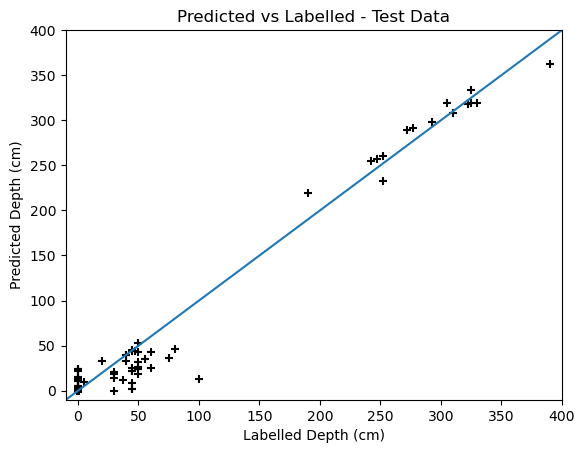

In [27]:
# Use the trained model to get predictions for training dataset
preds_train,_ = learn.get_preds(dl=dls.train)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_train, preds_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [28]:
# test performance on the holdout dataset

# make sure to do same feature-engineering steps to the test dataset (processing steps stored in learner but want to
# apply to a new dataset so just grab a test_dl object with same transforms stored)
tst_dl = learn.dls.test_dl(test_df)

In [29]:
# get predictions from data loaded in in the correct way
preds,_ = learn.get_preds(dl=tst_dl)

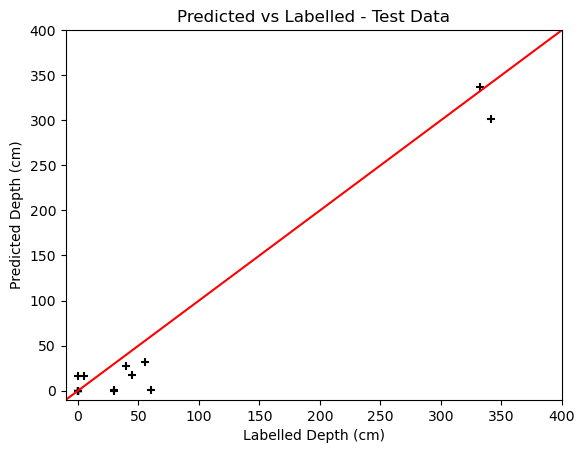

In [30]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [31]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", RMSE)

R Squared: 0.95396749321319
RMSE: 22.025687412670283


# Ensembling

In [32]:
# Simplest kind of ensembling is ensembling same kind of model but trained of different subsets of data
# Essentially make a model, fit the model, predict on test set and return predictions 

def ensemble():
    learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(25, lr=0.1)
    with learn.no_bar(),learn.no_logging(): learn.fit(10, lr=0.01)    
    return learn.get_preds(dl=tst_dl)[0]

In [33]:
# do this 5 times and store all predictions 
learns = [ensemble() for _ in range(5)]

In [34]:
ens_preds = torch.stack(learns).mean(0)

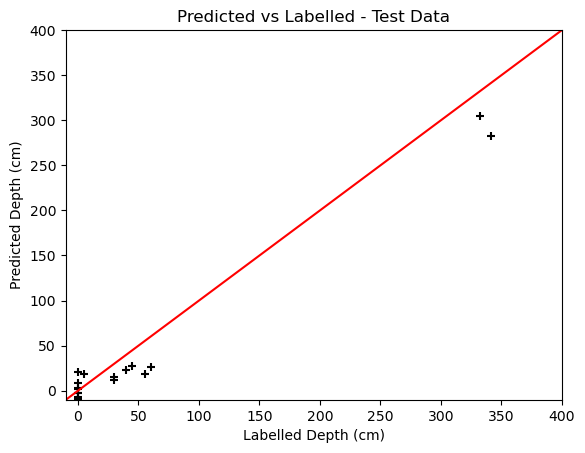

In [35]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, ens_preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [36]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, ens_preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, ens_preds, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9538973815367556
RMSE: 22.04245458888008


# Embeddings of categories 

We also want to try using embeddings as inputs to the random forests instead of only relying on the assumed numerical relationship bteween categories. Therefor we need a method for generating embeddings of the categorical variables, and then use these to make a new dataframe with the new relevant columns. 

In [37]:
# we can grab the fitted embeddings from the model that has already been trained (this trains parameters of embedding
# matrix for us)
# We only need to grab the embeddings of the features we actually want to use after our feature selection process 
MRRTF_embedding = learn.model.embeds[2]

Find the embeddings for every row in the train/val dataframe. Make a new dataframe with these embedding vectors appended to the dataframe

In [38]:
# for each row in dataframe we need to find the value of MRRTF and use this to get the equivalent 
# embedding which should then be added to the dataframe 
mrrtf_data = torch.LongTensor(df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
df_embed = pd.concat([df, embedding_vectors_df], axis=1)

Need to do the same process to the test dataframe also

In [39]:
mrrtf_data = torch.LongTensor(test_df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=test_df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
test_df_embed = pd.concat([test_df, embedding_vectors_df], axis=1)

Split the data into the explicit sub-splits that we need for modelling 

In [40]:
# for some models we need explicit datasets
x_train_embed = df_embed.iloc[splits_train_val[0],:].drop('depth', axis=1)
y_train_embed = df_embed.iloc[splits_train_val[0],:]['depth']

x_val_embed = df_embed.iloc[splits_train_val[1],:].drop('depth', axis=1)
y_val_embed = df_embed.iloc[splits_train_val[1],:]['depth']

# some models need explicit datasets
x_test_embed = test_df_embed.drop('depth', axis=1)
y_test_embed = test_df_embed['depth']

In [41]:
# check performance of random forest as a result
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train_embed, x_val_embed]), pd.concat([y_train_embed, y_val_embed])) 

RandomForestRegressor(oob_score=True, random_state=0)

In [42]:
# get the feature names from the column headings 
feature_names = [i for i in df_embed.columns]
feature_names.remove('depth')

# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

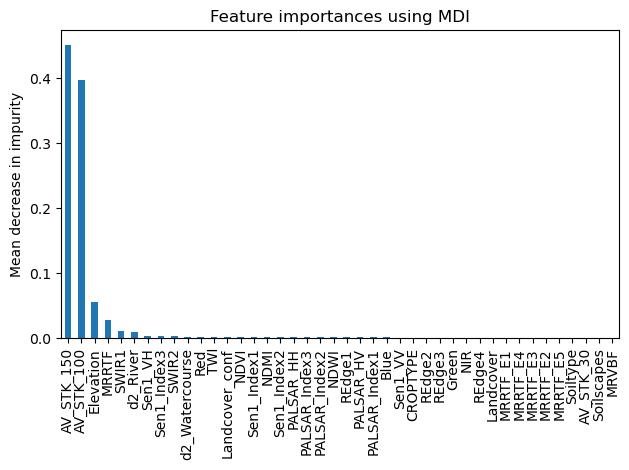

In [43]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [44]:
y_pred_train_val = rf_model.predict(pd.concat([x_train_embed, x_val_embed]))
y_pred_test = rf_model.predict(x_test_embed)

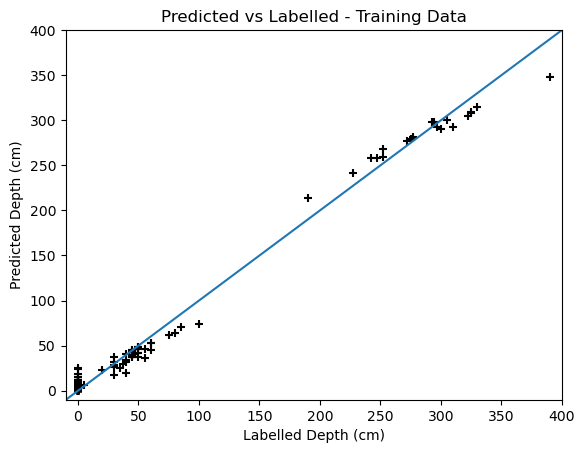

In [45]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [46]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9913558726678506
RMSE: 8.901668639932817


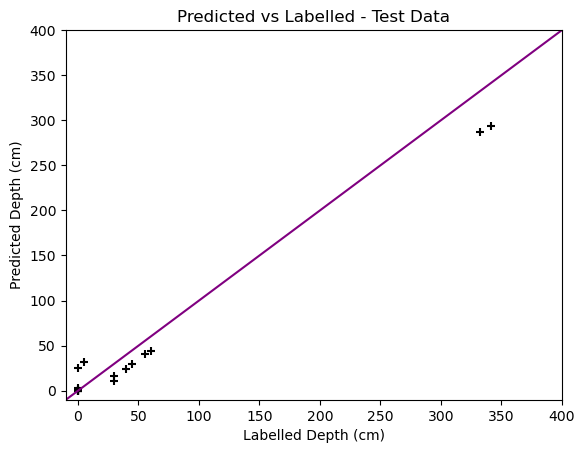

In [47]:
# add a scatter plot of the data points
plt.scatter(y_test_embed, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [48]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test_embed, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test_embed, y_pred_test, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9627357829154606
RMSE: 19.817239548769994
